# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples = 5):
### STUDENT START ###

    for i in range(num_examples):
        print 'Text at Index ' + str(i) + ':\n' + train_data[i] + '\n\nLabel for Index ' + str(i)\
              + ': ' + newsgroups_train.target_names[train_labels[i]] + '\n'
    
### STUDENT END ###

P1()

Text at Index 0:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Label for Index 0: comp.graphics

Text at Index 1:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for cen

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
### STUDENT START ###
    
    print 'a)'
    cv     = CountVectorizer()
    cv_fit = cv.fit_transform(train_data)
    print 'The vocabulary size is {}'.format(cv_fit.shape[1])
    print 'The average number of non-zero features is {}'.format(round(cv_fit.nnz / cv_fit.shape[0], 4))
    print 'The fraction of non-zero entries is {}'.format(round(float(cv_fit.nnz) / (cv_fit.shape[0] * cv_fit.shape[1]), 4))
    
    print '\nb)'
    print 'The first feature string is ' + cv.get_feature_names()[0]
    print 'The last feature string is ' + cv.get_feature_names()[-1]
    
    print '\nc)'
    my_vocab = ["atheism", "graphics", "space", "religion"]
    my_cv    = CountVectorizer(vocabulary = my_vocab)
    my_fit   = my_cv.fit_transform(train_data)
    print 'Confirm training vectors are appropriately shaped: {}'.format(my_fit.shape)
    print 'The new average number of non-zero features is {}'.format(round(float(my_fit.nnz) / my_fit.shape[0], 4))
    
    print '\nd)'
    bigram_trigram     = CountVectorizer(analyzer = 'char', ngram_range = (2, 3))
    bigram_trigram_fit = bigram_trigram.fit_transform(train_data)
    print 'The bigram and trigram vocabulary size is {}'.format(bigram_trigram_fit.shape[1])
    
    print '\ne)'
    min_cv     = CountVectorizer(min_df = 10)
    min_cv_fit = min_cv.fit_transform(train_data)
    print 'The minimum 10 documents per word vocabulary size is {}'.format(min_cv_fit.shape[1])
    
    print '\nf)' 
    cv_dev     = CountVectorizer()
    cv_dev_fit = cv_dev.fit_transform(dev_data)
    print 'The fraction of dev words not in the training vocabulary is {}'\
          .format(round(float(len(np.setdiff1d(cv_dev.get_feature_names(), cv.get_feature_names()))) / cv_dev_fit.shape[1], 4))
    
### STUDENT END ###

P2()

a)
The vocabulary size is 26879
The average number of non-zero features is 96.0
The fraction of non-zero entries is 0.0036

b)
The first feature string is 00
The last feature string is zyxel

c)
Confirm training vectors are appropriately shaped: (2034, 4)
The new average number of non-zero features is 0.2684

d)
The bigram and trigram vocabulary size is 35478

e)
The minimum 10 documents per word vocabulary size is 3064

f)
The fraction of dev words not in the training vocabulary is 0.2479


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():
### STUDENT START ###

    # a)
    cv           = CountVectorizer()
    cv_train     = cv.fit_transform(train_data)
    cv_dev_fit   = cv.transform(dev_data)
    optimal_k    = 0
    max_f1_score = 0
    
    for i in range(1, 20):
        knn        = KNeighborsClassifier(n_neighbors = i).fit(cv_train, train_labels)
        dev_preds  = knn.predict(cv_dev_fit)
        f1_score_k = metrics.f1_score(dev_labels, dev_preds, average = 'weighted')
        
        if f1_score_k > max_f1_score:
            max_f1_score = f1_score_k
            optimal_k    = i
        
    print 'a)\nThe optimal value for k is {} with an F1 Score of {:.4}'.format(optimal_k, max_f1_score)
    
    # b)
    alphas           = [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    optimal_alpha    = 0
    max_f1_score_mnb = 0
    
    for alpha_ in alphas:
        mnb            = MultinomialNB(alpha = alpha_).fit(cv_train, train_labels)
        mnb_preds      = mnb.predict(cv_dev_fit)
        f1_score_alpha = metrics.f1_score(dev_labels, mnb_preds, average = 'weighted')
        
        if f1_score_alpha > max_f1_score_mnb:
            max_f1_score_mnb = f1_score_alpha
            optimal_alpha    = alpha_
    
    print '\nb)\nThe best alpha value is {} with an F1 Score of {:.4}'.format(optimal_alpha, max_f1_score_mnb)
    
    # c)
    print '\nc)'
    c_values        = [1e-2, 1e-1, 1, 10, 100]
    optimal_c       = 0
    max_f1_score_lr = 0
    
    for c_ in c_values:
        lr                  = LogisticRegression(C = c_).fit(cv_train, train_labels)
        dev_preds           = lr.predict(cv_dev_fit)
        f1_score_c          = metrics.f1_score(dev_labels, dev_preds, average = 'weighted')
        sum_weights_squared = []
        
        for label in lr.coef_:
            sum_weights_squared.append(round(sum(label ** 2), 4))
        
        print 'C = {} ; f1_score = {}'.format(c_, f1_score_c)
        row_format = '{:<20}' * (len(newsgroups_train.target_names))
        print row_format.format(* newsgroups_train.target_names)
        print row_format.format(* sum_weights_squared)
    
        if f1_score_c > max_f1_score_lr:
            max_f1_score_lr = f1_score_c
            optimal_c = c_
    
    print '\nThe optimal value for C is {}'.format(optimal_c)
    
### STUDENT END ###

P3()

a)
The optimal value for k is 7 with an F1 Score of 0.4505

b)
The best alpha value is 0.1 with an F1 Score of 0.7903

c)


/anaconda2/lib/python2.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


C = 0.01 ; f1_score = 0.664699741758
alt.atheism         comp.graphics       sci.space           talk.religion.misc  
2.5415              2.9397              2.8625              2.25                
C = 0.1 ; f1_score = 0.696624354242
alt.atheism         comp.graphics       sci.space           talk.religion.misc  
27.1295             24.659              27.4577             23.0261             
C = 1 ; f1_score = 0.696086251954
alt.atheism         comp.graphics       sci.space           talk.religion.misc  
166.9839            130.9093            157.9449            145.7368            
C = 10 ; f1_score = 0.686478292788
alt.atheism         comp.graphics       sci.space           talk.religion.misc  
586.1354            448.1432            539.2522            530.9443            
C = 100 ; f1_score = 0.682809285362
alt.atheism         comp.graphics       sci.space           talk.religion.misc  
1404.3357           1081.8731           1269.0385           1315.2471           

The optimal

ANSWER:

a) K nearest neighbors does not work well in this problem because the large number of features introduces the possibility that one word could create noise if k is too small.

b) Logistic regression will account for correlations between features. Since there are several thousand features to correlate, this will likely mean there is a lot of noise causing an inferior model.

c) As the regularization strength C increases, the sum of squared weights also increases. So as we attempt to make the model more generalized, we're seeing features have much higher absolute weights than non-generalized training weights.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [6]:
def P4():
### STUDENT START ###

    cv              = CountVectorizer()
    cv_train        = cv.fit_transform(train_data)
    lr              = LogisticRegression().fit(cv_train, train_labels)
    # I chose to use the word bigram because I thought that would be more interesting to explore than character bigrams
    cv_bigram       = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
    cv_bigram_train = cv_bigram.fit_transform(train_data)
    lr_bigram       = LogisticRegression().fit(cv_bigram_train, train_labels)
    top_indexes     = []
    top_indexes_bi  = []
    
    # Gather the top 5 standard CountVectorizer features for each label
    for i in range(len(lr.coef_)):
        top_feature_values = sorted(lr.coef_[i], reverse = True)[0:5]
        
        for j in top_feature_values:
            top_indexes.append(int(np.where(lr.coef_[i] == j)[0]))
            
    # Print the standard CountVectorizer table
    print 'Standard CountVectorizer Logistic Regression Features\n'
    row_format = '{:<20}' * (len(newsgroups_train.target_names) + 1)
    print row_format.format('', * newsgroups_train.target_names)
    
    for i in top_indexes:
        print_list = []
        
        for j in range(len(lr.coef_)):
            print_list.append(round(lr.coef_[j][i], 4))
            
        print row_format.format(cv.get_feature_names()[i], *print_list)
        
    # Gather the top 5 bigram CountVectorizer features for each label
    for i in range(len(lr_bigram.coef_)):
        top_feature_values_bi = sorted(lr_bigram.coef_[i], reverse = True)[0:5]
        
        for j in top_feature_values_bi:
            top_indexes_bi.append(int(np.where(lr_bigram.coef_[i] == j)[0]))
    
    # Print the bigram CountVectorizer table
    print '\nBigram CountVectorizer Logistic Regression Features\n'
    row_format = '{:<20}' * (len(newsgroups_train.target_names) + 1)
    print row_format.format('', * newsgroups_train.target_names)
    
    for i in top_indexes_bi:
        print_list = []
        
        for j in range(len(lr_bigram.coef_)):
            print_list.append(round(lr_bigram.coef_[j][i], 4))
            
        print row_format.format(cv_bigram.get_feature_names()[i], *print_list)
    
### STUDENT END ###

P4()

Standard CountVectorizer Logistic Regression Features

                    alt.atheism         comp.graphics       sci.space           talk.religion.misc  
deletion            1.125               -0.3982             -0.4204             -0.3956             
atheists            1.0291              -0.0973             -0.3206             -0.8351             
bobby               0.9903              -0.2208             -0.3407             -0.4634             
religion            0.9541              -0.6169             -0.7924             -0.0643             
atheism             0.9392              -0.4103             -0.4493             -0.4345             
graphics            -0.7588             1.937               -1.336              -0.7627             
image               -0.5822             1.3468              -0.8259             -0.469              
file                -0.3348             1.2667              -0.8064             -0.6266             
3d                  -0.3592         

ANSWER: The first thing I noticed is for each word or bigram that was in the top 5 for that label, the feature held a negative weight for other labels almost all the time. The bigram table table shows that of the 20 features listed, nearly all of them have a word that likely would be classifed as a stopword, such as that, are, is, and the. These words show up most often and have very little impact on which classification the text will get. It's also interesting that the top 5 feature weights of the bigram model per label are much lower than the standard model. It's possible that these stopwords are introducing too much noise and detracting from model performance.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [7]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    # Replace any non-alphanumeric, non-whitespace character with a string length 0
    s = re.sub('[^a-z0-9\s\/]', '', s.lower())
    
    # Replace any numeric set of characters with ' numberreplace ' so it does not affect other tokens
    s = re.sub('[0-9]+', ' numberreplace ', s)
    
    return s
    
### STUDENT END ###

def P5():
### STUDENT START ###

    # Run the empty preprocessor vectorizer and model
    cv_empty     = CountVectorizer(preprocessor = empty_preprocessor)
    cv_empty_fit = cv_empty.fit_transform(train_data)
    dev_empty    = cv_empty.transform(dev_data)
    lr_empty     = LogisticRegression().fit(cv_empty_fit, train_labels)
    empty_preds  = lr_empty.predict(dev_empty)
    print 'The empty preprocessor has an F1 Score of {}'.format(\
          round(metrics.f1_score(dev_labels, empty_preds, average = 'weighted'), 4))
    
    # In addition to the better preprocessor, add the stop_words = 'english' parameter to the vectorizer
    cv_better     = CountVectorizer(preprocessor = better_preprocessor, stop_words = 'english')
    cv_better_fit = cv_better.fit_transform(train_data)
    dev_better    = cv_better.transform(dev_data)
    lr_better     = LogisticRegression().fit(cv_better_fit, train_labels)
    better_preds  = lr_better.predict(dev_better)
    print 'The better preprocessor has an F1 Score of {}'.format(\
          round(metrics.f1_score(dev_labels, better_preds, average = 'weighted'), 4))
    print 'My preprocessor improved dev F1 by {}'.format(\
          round(metrics.f1_score(dev_labels, better_preds, average = 'weighted'), 4)\
          - round(metrics.f1_score(dev_labels, empty_preds, average = 'weighted'), 4))
    
    print '\nThe better preprocessor vocabulary size is {}, compared to the empty preprocessor size of {}'\
          .format(cv_better_fit.shape[1], cv_empty_fit.shape[1])
        
    print '\nI found it interesting that adding an empty preprocessor yields different results than not having'\
          ' that parameter at all (comparing dictionary size between empty preprocessor and that from P2 a))'
    
### STUDENT END ###

P5()

The empty preprocessor has an F1 Score of 0.7023
The better preprocessor has an F1 Score of 0.722
My preprocessor improved dev F1 by 0.0197

The better preprocessor vocabulary size is 25943, compared to the empty preprocessor size of 33291

I found it interesting that adding an empty preprocessor yields different results than not having that parameter at all (comparing dictionary size between empty preprocessor and that from P2 a))


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

                    alt.atheism         comp.graphics       sci.space           talk.religion.misc  
Non-zero L1 weights 477                 400                 464                 473                 
Non-zero L2 weights 26879               26879               26879               26879               
[[ 0.45575221  0.46066863]
 [ 0.66912488  0.67109145]
 [ 0.73992134  0.75417896]
 [ 0.74877089  0.78416912]
 [ 0.72025565  0.78220256]]


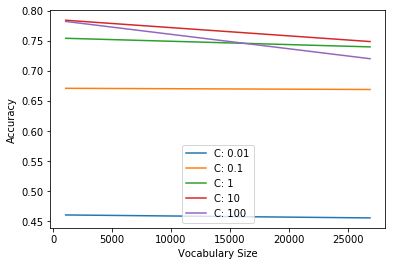

In [4]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

### STUDENT START ###
    
    cv_l1            = CountVectorizer()
    cv_train_l1      = cv_l1.fit_transform(train_data)
    lr_l1            = LogisticRegression(penalty = 'l1').fit(cv_train_l1, train_labels)
    print_list_l1    = ['Non-zero L1 weights']
    non_zero_indexes = []
    
    for i in range(len(lr_l1.coef_)):
        print_list_l1.append(sum(lr_l1.coef_[i] <> 0))
        
        for j in range(len(lr_l1.coef_[i])):
            if lr_l1.coef_[i][j] <> 0:
                non_zero_indexes.append(j)
    
    keep_features = [cv_l1.get_feature_names()[k] for k in list(set(non_zero_indexes))]
    
    cv_l2         = CountVectorizer()
    cv_train_l2   = cv_l2.fit_transform(train_data)
    lr_l2         = LogisticRegression(penalty = 'l2').fit(cv_train_l2, train_labels)
    print_list_l2 = ['Non-zero L2 weights']
    
    for m in lr_l2.coef_:
        print_list_l2.append(sum(m <> 0))
    
    row_format = '{:<20}' * (len(newsgroups_train.target_names) + 1)
    print row_format.format('', * newsgroups_train.target_names)
    print row_format.format(* print_list_l1)
    print row_format.format(* print_list_l2)
    
    cv_l2_pruned       = CountVectorizer(vocabulary = keep_features)
    cv_train_l1_pruned = cv_l1_pruned.fit_transform(train_data)
    lr_l1_pruned       = LogisticRegression(penalty = 'l1', tol = .01)
    c_values           = {'C': [1e-2, 1e-1, 1, 10, 100]}
    grid_search        = GridSearchCV(lr_l1, c_values)
    grid_search_pruned = GridSearchCV(lr_l1_pruned, c_values)
    grid_search.fit(cv_train_l1, train_labels)
    grid_search_pruned.fit(cv_train_l1_pruned, train_labels)
    
    accuracies        = [n[1] for n in grid_search.grid_scores_]
    pruned_accuracies = [o[1] for o in grid_search_pruned.grid_scores_]
    all_accuracies    = []
    
    for p in range(len(accuracies)):
        all_accuracies.append(accuracies[p])
        all_accuracies.append(pruned_accuracies[p])
    
    all_accuracies = np.array(all_accuracies).reshape(len(c_values.values()[0]), 2)
    
    print 'The '
    
    for ind, i in enumerate(c_values.values()[0]):
        plt.plot([cv_train_l1.shape[1], cv_train_l1_pruned.shape[1]], all_accuracies[ind], label = 'C: ' + str(i))
    plt.legend()
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Accuracy')
    plt.show()
    
### STUDENT END ###
    
P6()

In [9]:
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

digits = datasets.load_digits()
X = digits.data
y = digits.target

clf_ = SVC(kernel='rbf')
Cs = [1, 10, 100, 1000]
Gammas = [1e-3, 1e-4]
clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=2,
                 pre_dispatch='1*n_jobs',
                 n_jobs=1)

clf.fit(X, y)

scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))
#print clf.grid_scores_
print scores
#scores = np.array(scores).reshape(len(Cs), len(Gammas))
'''
for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()
'''

[[ 0.96048971  0.93600445]
 [ 0.96271564  0.94546466]
 [ 0.96271564  0.94657763]
 [ 0.96271564  0.94657763]]


"\nfor ind, i in enumerate(Cs):\n    plt.plot(Gammas, scores[ind], label='C: ' + str(i))\nplt.legend()\nplt.xlabel('Gamma')\nplt.ylabel('Mean score')\nplt.show()\n"

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [16]:
#def P7():
### STUDENT START ###



## STUDENT END ###

#P7()

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.